# An optimization method for Paleomagnetic Euler Pole analysis

Authors: [L. C. Gallo](https://github.com/LenGallo) (l.c.gallo@geo.uio.no), [F. Sapienza](https://github.com/facusapienza21), and [M. Domeier](https://github.com/matdomeier).

In this notebook we show how to fit a segment of an aparent polar wander path by minimizing a loss function that estimates the missfit between a series of paleomagnetic poles and an arc segment generetad by the rotation around an Euler pole (small circle). 

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
import cartopy.crs as ccrs

from auxiliar.utils import GCD_cartesian, spherical2cartesian, cartesian2spherical
from auxiliar.utils_synthetic import generate_APWP_segment_noiseless

# Matplotlib global parameters
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 12

# Set seed for reproducibility of the results
np.random.seed(1)

### Step 1 - Setup

Consider a set of three dimensional points $\{ (x_i, y_i, z_i) \}_{i=1}^N \subset \mathbb R^3$ contained in the three-dimensional sphere, that is, each one of the data points satisfy the equation $x_i^2 + y_i^2 + z_i^2 = 1$. We use the Cartesian coordinates $(x, y, z)$ and spherical coordinates $(\theta, \varphi)$ interchangeably, where both representations are connected via the set of equations

\begin{align}
    x &= \sin \theta \cos \varphi, \nonumber \\
    y &= \sin \theta \sin \varphi, \label{eq:spherical_coordinates}\\
    z &= \cos \theta. \nonumber
\end{align}


We are going to consider a path described by a total of $N$ idealized (noiseless) paleomagnetic poles (PPs) organized in a single segment, inside this segment the orientation of the Euler Pole (EP) and the angular speed is constant. 

We then proceed to the population of a synthetic segment

In [3]:
N      = 30                   # number of Paleomagnetic Poles 
EPlat  = -45                  # coordinates of the Euler Pole
EPlong = 30                   # coordinates of the Euler Pole
omega  = np.radians(1.5)      # Euler Pole velocity

APWP = generate_APWP_segment_noiseless(N, spherical2cartesian([np.radians(EPlat), np.radians(EPlong)]), omega)
APWP_spherical = np.array([cartesian2spherical(i) for i in APWP])

This is a simple visualization showing how thet synthetic paleomagnetic poles are distributed. 

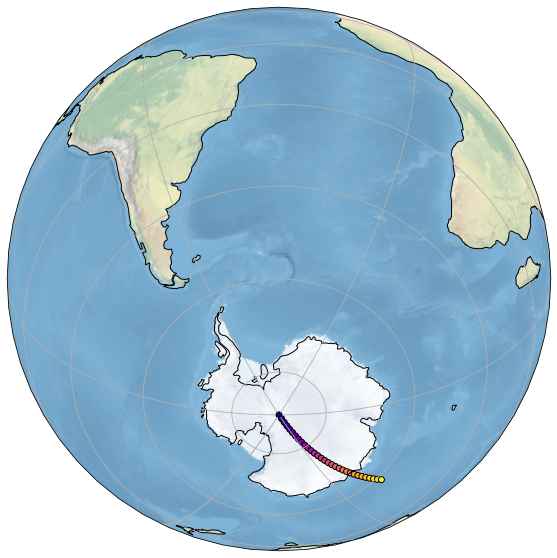

In [5]:
fig = plt.figure()

proj = ccrs.Orthographic(-30, -60)

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

ax.scatter(x = np.degrees(APWP_spherical[:,1]), y = np.degrees(APWP_spherical[:,0]),
           c = np.array(range(len(APWP_spherical))), cmap="plasma", 
           Label = "Synthetic APWP", edgecolors='black',
           transform=ccrs.PlateCarree())

plt.show()

### Step 2: Estimation of Paleomagnetic Euler Pole for a Single segment

First, we define the cost function that we will use to compute the goodness of fit of a single segment. This cost function is given by

$$ \sum_{i=k}^{m-1} \left ( \cos^{-1}(x_i x_q  + y_i y_q + z_i z_q) - \varphi  \right )^2 $$


In [6]:
PPs = APWP

def loss (v):
    
    theta = v[0]
    phi = v[1]
    varphi = v[2]
    
    res = 0
    pole = spherical2cartesian([theta, phi])
    
    for i in range(PPs.shape[0]):
        res += ( np.arccos( np.dot( PPs[i,:], pole)) - varphi ) ** 2        
    return res

We consider an optimization problem that seeks to minimize the cost function with respect to the three parameters of the circle that we write as the three-dimensional vector $\Theta = ( \phi_q, \theta_q, \varphi )$.

In contrast to the ordinary least square method, this optimization problem has no analytical solutions. However, we can use the method of gradient descent in order to find an optimal solution.  The gradient descent algorithm computes the gradient of the cost function and updates model parameters through $N_{iter}$ descent steps.

In [7]:
# initial guess of the three-dimensional vector.
initialGuess = [np.random.uniform(-np.pi/2,np.pi/2),np.random.uniform(0,2*np.pi),np.random.uniform(-np.pi/2,np.pi/2)]

# with contraints method= 'CG'
optimum = minimize(fun = loss, x0 = np.array(initialGuess), method='CG')

# ensures we stay within our stipulated constraints, and for visualization purposes
[theta, phi] = cartesian2spherical(spherical2cartesian([optimum.x[0],optimum.x[1]])) 

print(np.degrees(theta), np.degrees(phi))

-45.00190012040467 30.001205611980637


We can visualize the APWP with the results too. For the noiseless case, we can see how the estimated Euler pole coincide with the simulated one. 

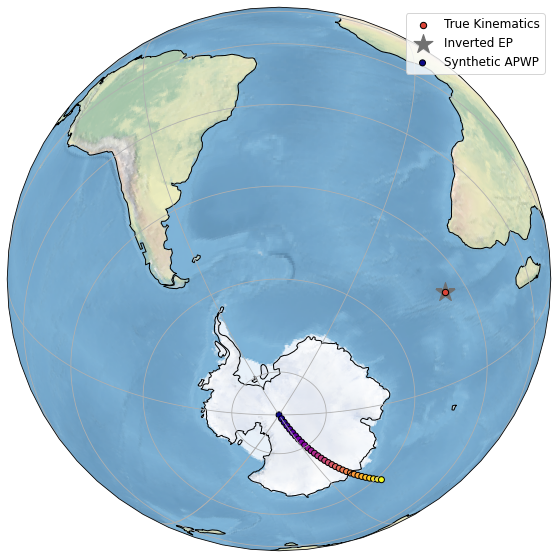

In [9]:
fig = plt.figure()

proj = ccrs.Orthographic(-30, -60)

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

ax.scatter(x = np.degrees(APWP_spherical[:,1]), y = np.degrees(APWP_spherical[:,0]),
           c = np.array(range(len(APWP_spherical))), cmap="plasma", 
           Label = "Synthetic APWP", edgecolors='black',
           transform=ccrs.PlateCarree())

# Calculates the backwards EP in order to visualize it on the SH
if theta > 0: 
    theta = -theta
    if phi < 0 or phi > np.pi:
        phi = phi + np.pi
    else:
        phi = phi - np.pi

plt.scatter(x = np.degrees(phi), y = np.degrees(theta), color= "#707070", s = 400, marker = "*",
            Label = "Inverted EP",
            transform=ccrs.PlateCarree())

ax.scatter(EPlong, EPlat, color = "#DB4437", edgecolors='black',
           Label = "True Kinematics", s = 40,
           transform=ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()